In [ ]:
#| default_exp data

# Loading the data

> First comes first: data **really** is all you need.

To begin with our project, we are going to try to load the TID2008 dataset using the `DataBlock` API.

In [ ]:
#| hide
import os; os.environ['CUDA_VISIBLE_DEVICES']='-1'

In [ ]:
#| export
import re

import pandas as pd
from fastai.data.all import *
from fastai.vision.all import *

TID2008 is already present on our server, but one may find it a little bit confusing to load: there is a `mos_with_names.txt` file that connects each distorted image with its MOS, the reference images are in the `reference_images` foldes, and the distorted images are in the `distorted_images` folder. This means that we will have to load both folders and connect the corresponding images with the `mos_with_names.txt` file.

Another important thing to note is that each distorted image is named in a meaningful way: `I(img_id)_(dist_id)_(dist_int).bmp`, so we may use that information at our discretion. Leaving complicated filterings aside, we can start by loading all the images and connecting them.

We will start by loading the `mos_with_names.txt` file defining our `DataBlock`:

In [ ]:
#| hide
path_root = Path("/media/disk/databases/BBDD_video_image/Image_Quality/TID/TID2008/")
path_txt = path_root/"mos_with_names.txt"
path_ref = path_root/"reference_images"
path_dist = path_root/"distorted_images"

In [ ]:
df = pd.read_csv(path_txt, header=None, sep=" ", names=["MOS", "Dist"])
df.head()

,MOS,Dist
0,5.9706,i01_01_1.bmp
1,5.4167,i01_01_2.bmp
2,4.5556,i01_01_3.bmp
3,4.3143,i01_01_4.bmp
4,6.1429,i01_02_1.bmp


:::{.callout-warning}

Turns out that the filenames in the `.txt` file are lowercase but the filenames of the images are uppercase. Because we can't modify any of those to avoid breaking other's people code, we have to uppercase the **initial I** of the image names in the loaded dataframe.

:::

In [ ]:
#| exporti
def fix_dist_name(name):
    file, extension = name.split(".")
    file, extension = file.upper(), extension.lower()
    return ".".join([file, extension])

In [ ]:
df['Dist'] = df.Dist.apply(fix_dist_name)
df.head()

,MOS,Dist
0,5.9706,I01_01_1.bmp
1,5.4167,I01_01_2.bmp
2,4.5556,I01_01_3.bmp
3,4.3143,I01_01_4.bmp
4,6.1429,I01_02_1.bmp


To avoid unnecessary hustle, we can a column to our dataframe that points to the corresponding `reference_image` and we should be good to go. Keep in mind that, as we should be expecting this far in, reference images are all in uppercase format (extension included), so we'll have to adjust consequently.

In [ ]:
#| exporti
def get_ref_name(dist_name):
    file, extension = re.search(r"(.+)_\d+_\d+\.(.+)", dist_name).groups()
    return ".".join((file, extension)).upper()

In [ ]:
a = "I01_01_1.bmp"
assert get_ref_name(a) == 'I01.BMP'

In [ ]:
df['Ref'] = df.Dist.apply(get_ref_name)
df.head()

,MOS,Dist,Ref
0,5.9706,I01_01_1.bmp,I01.BMP
1,5.4167,I01_01_2.bmp,I01.BMP
2,4.5556,I01_01_3.bmp,I01.BMP
3,4.3143,I01_01_4.bmp,I01.BMP
4,6.1429,I01_02_1.bmp,I01.BMP


In [ ]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock, RegressionBlock),
                   getters=[ColReader(2, pref=path_ref),
                            ColReader(1, pref=path_dist),
                            ColReader(0)],
                   n_inp=2)

In [ ]:
dls = dblock.dataloaders(df, bs=4)

We have a kind of "complicated" data with two input images and one output, so we can't use the base `.show_batch()` method right away. Instead, we can iterate over the `DataLoader` by hand to plot the data:

In [ ]:
for img_ref, img_dist, mos in dls.train:
    break

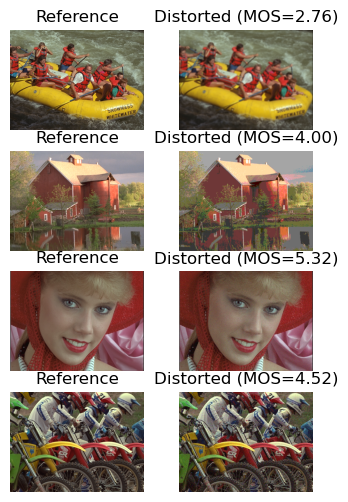

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(4,6))

for i in range(len(axes)):
    axes[i,0].imshow(img_ref[i].permute(1,2,0))
    axes[i,0].set_title("Reference")
    axes[i,1].imshow(img_dist[i].permute(1,2,0))
    axes[i,1].set_title(f"Distorted (MOS={mos[i]:.2f})")

for ax in axes.ravel(): ax.axis('off')

plt.show()